# CLIPT Evaluation

Evaluating whether we are able to achieve diagonals in trajectory-text pair similarity matrices.

In [1]:
import os
from IPython.display import display
from PIL import Image

import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from nlgoals.data.calvin.datamodule import CALVINDM
from nlgoals.data.transforms import CLIPTPrepare
from nlgoals.models.clipt import CLIPT

In [2]:
# disable tokenizer parallelism because we have multiple workers
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Data

In [3]:
clipt_prepare = CLIPTPrepare(
    image_col="rgb_static",
    input_ids_col="text_input_ids",
    attn_mask_col="text_attn_mask",
    clip_model="laion/CLIP-ViT-L-14-laion2B-s32B-b82K",
    image_cols=["rgb_static"],
    text_col="lang_ann",
)

In [4]:
calvin = CALVINDM(
    "../data/calvin/calvin_debug_dataset",
    num_frames=2,
    batch_size=1,
    val_split=0.1,
    seed=42,
    num_workers=4,
    frame_keys=["rgb_static"],
    transform=clipt_prepare,
)

In [5]:
calvin.prepare_data()
calvin.setup(stage='debug')

Data found.


## Model

In [6]:
clipt = CLIPT(
    clip_model="laion/CLIP-ViT-L-14-laion2B-s32B-b82K", num_frames=2, freeze_clip=True
)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [7]:
checkpoint = torch.load(
    "../checkpoints/clipt/clipt.ckpt", map_location=torch.device("cpu")
)

In [8]:
clipt.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

## Inference

In [9]:
def heatmap_pipeline(dataloader):
    traj_vecs = []
    text_vecs = []

    for batch in tqdm(dataloader, total=len(dataloader)):
        # squeeze cuz batch size is 1
        traj_vecs.append(clipt.encode_visual_traj(batch["images"]).squeeze())
        text_vecs.append(
            clipt.encode_text_traj(
                batch["text_input_ids"], batch["text_attn_mask"]
            ).squeeze()
        )

    traj_tensor = torch.vstack(traj_vecs)
    text_tensor = torch.vstack(text_vecs)

    similarity_matrix = text_tensor @ traj_tensor.T
    probability_matrix = similarity_matrix.softmax(dim=1)

    f, (ax1, ax2) = plt.subplots(1, 2, dpi=300, figsize=(16, 9), sharey=True)

    ax1 = sns.heatmap(
        probability_matrix.detach().numpy(),
        ax=ax1,
        square=True,
        cbar_kws={"orientation": "horizontal", "location": "top"},
    )
    ax1.set_title("Softmaxed Probability")
    ax1.set_ylabel("Text Embeddings idxs")

    ax2 = sns.heatmap(
        similarity_matrix.detach().numpy(),
        ax=ax2,
        square=True,
        cbar_kws={"orientation": "horizontal", "location": "top"},
    )
    ax2.set_title("Similarity")
    
    f.set_tight_layout(True)
    plt.show()

### Train

100%|█████████████████████████████████████████████████████████████████████████| 8/8 [01:10<00:00,  8.86s/it]


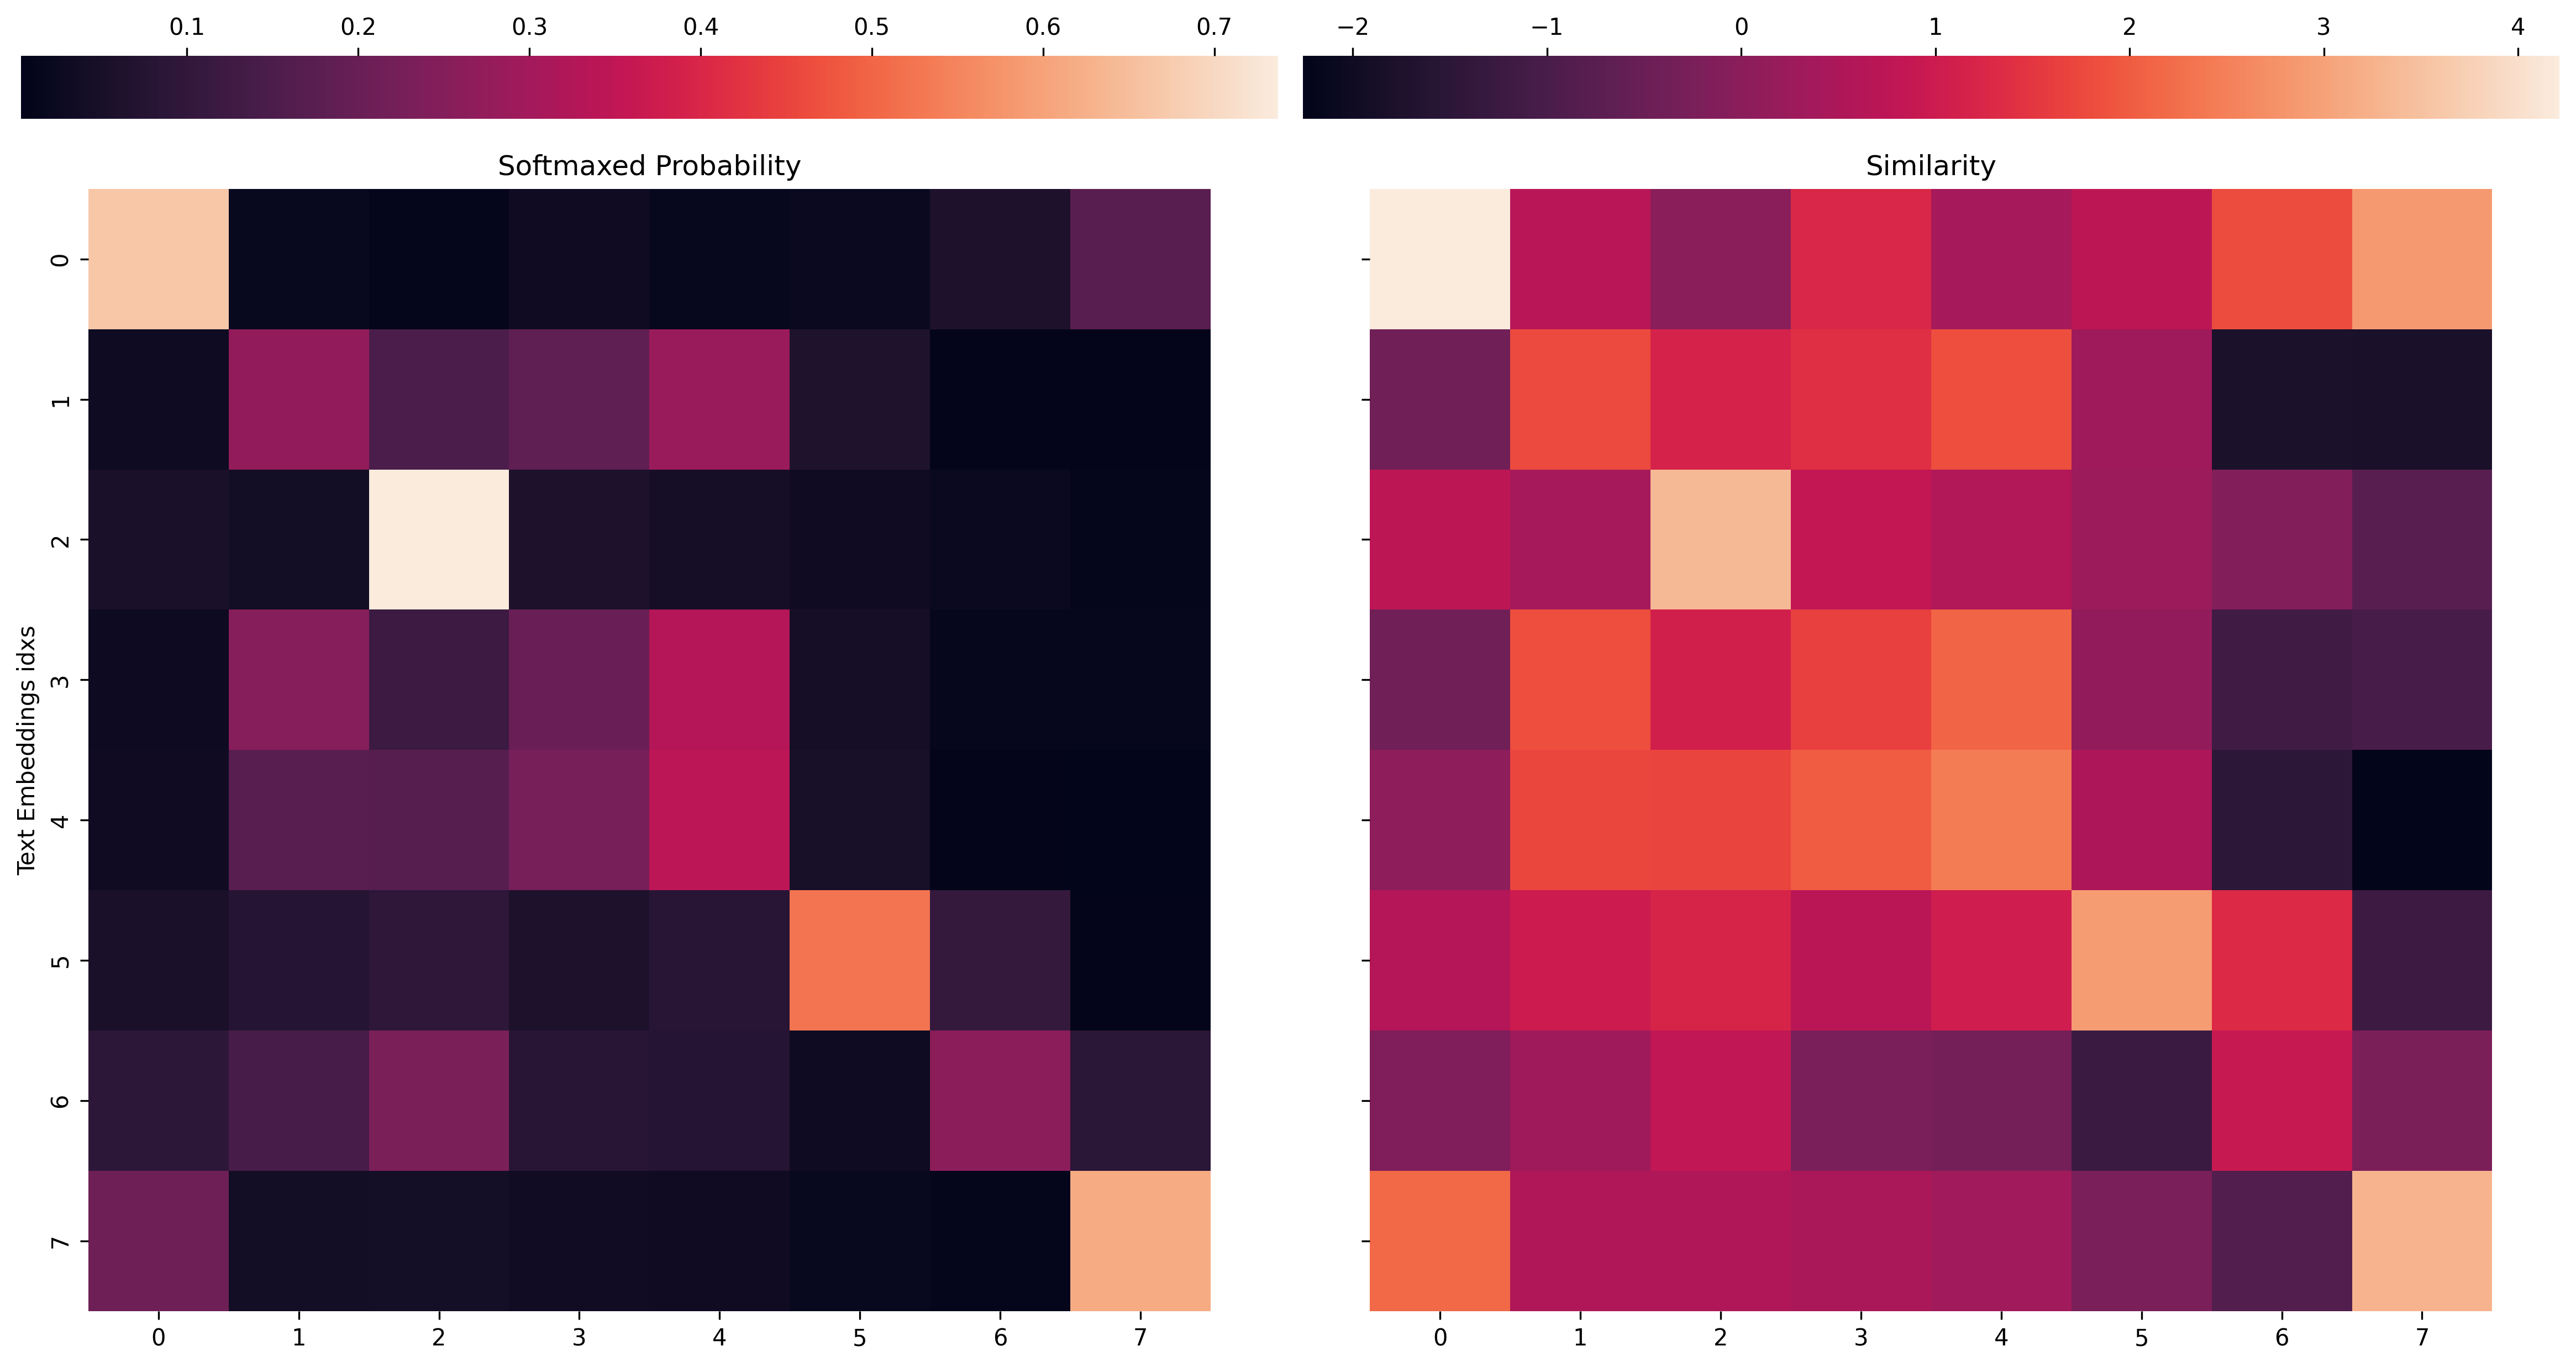

In [10]:
heatmap_pipeline(calvin.train_debug_dataloader())

### Val

100%|█████████████████████████████████████████████████████████████████████████| 8/8 [01:03<00:00,  7.92s/it]


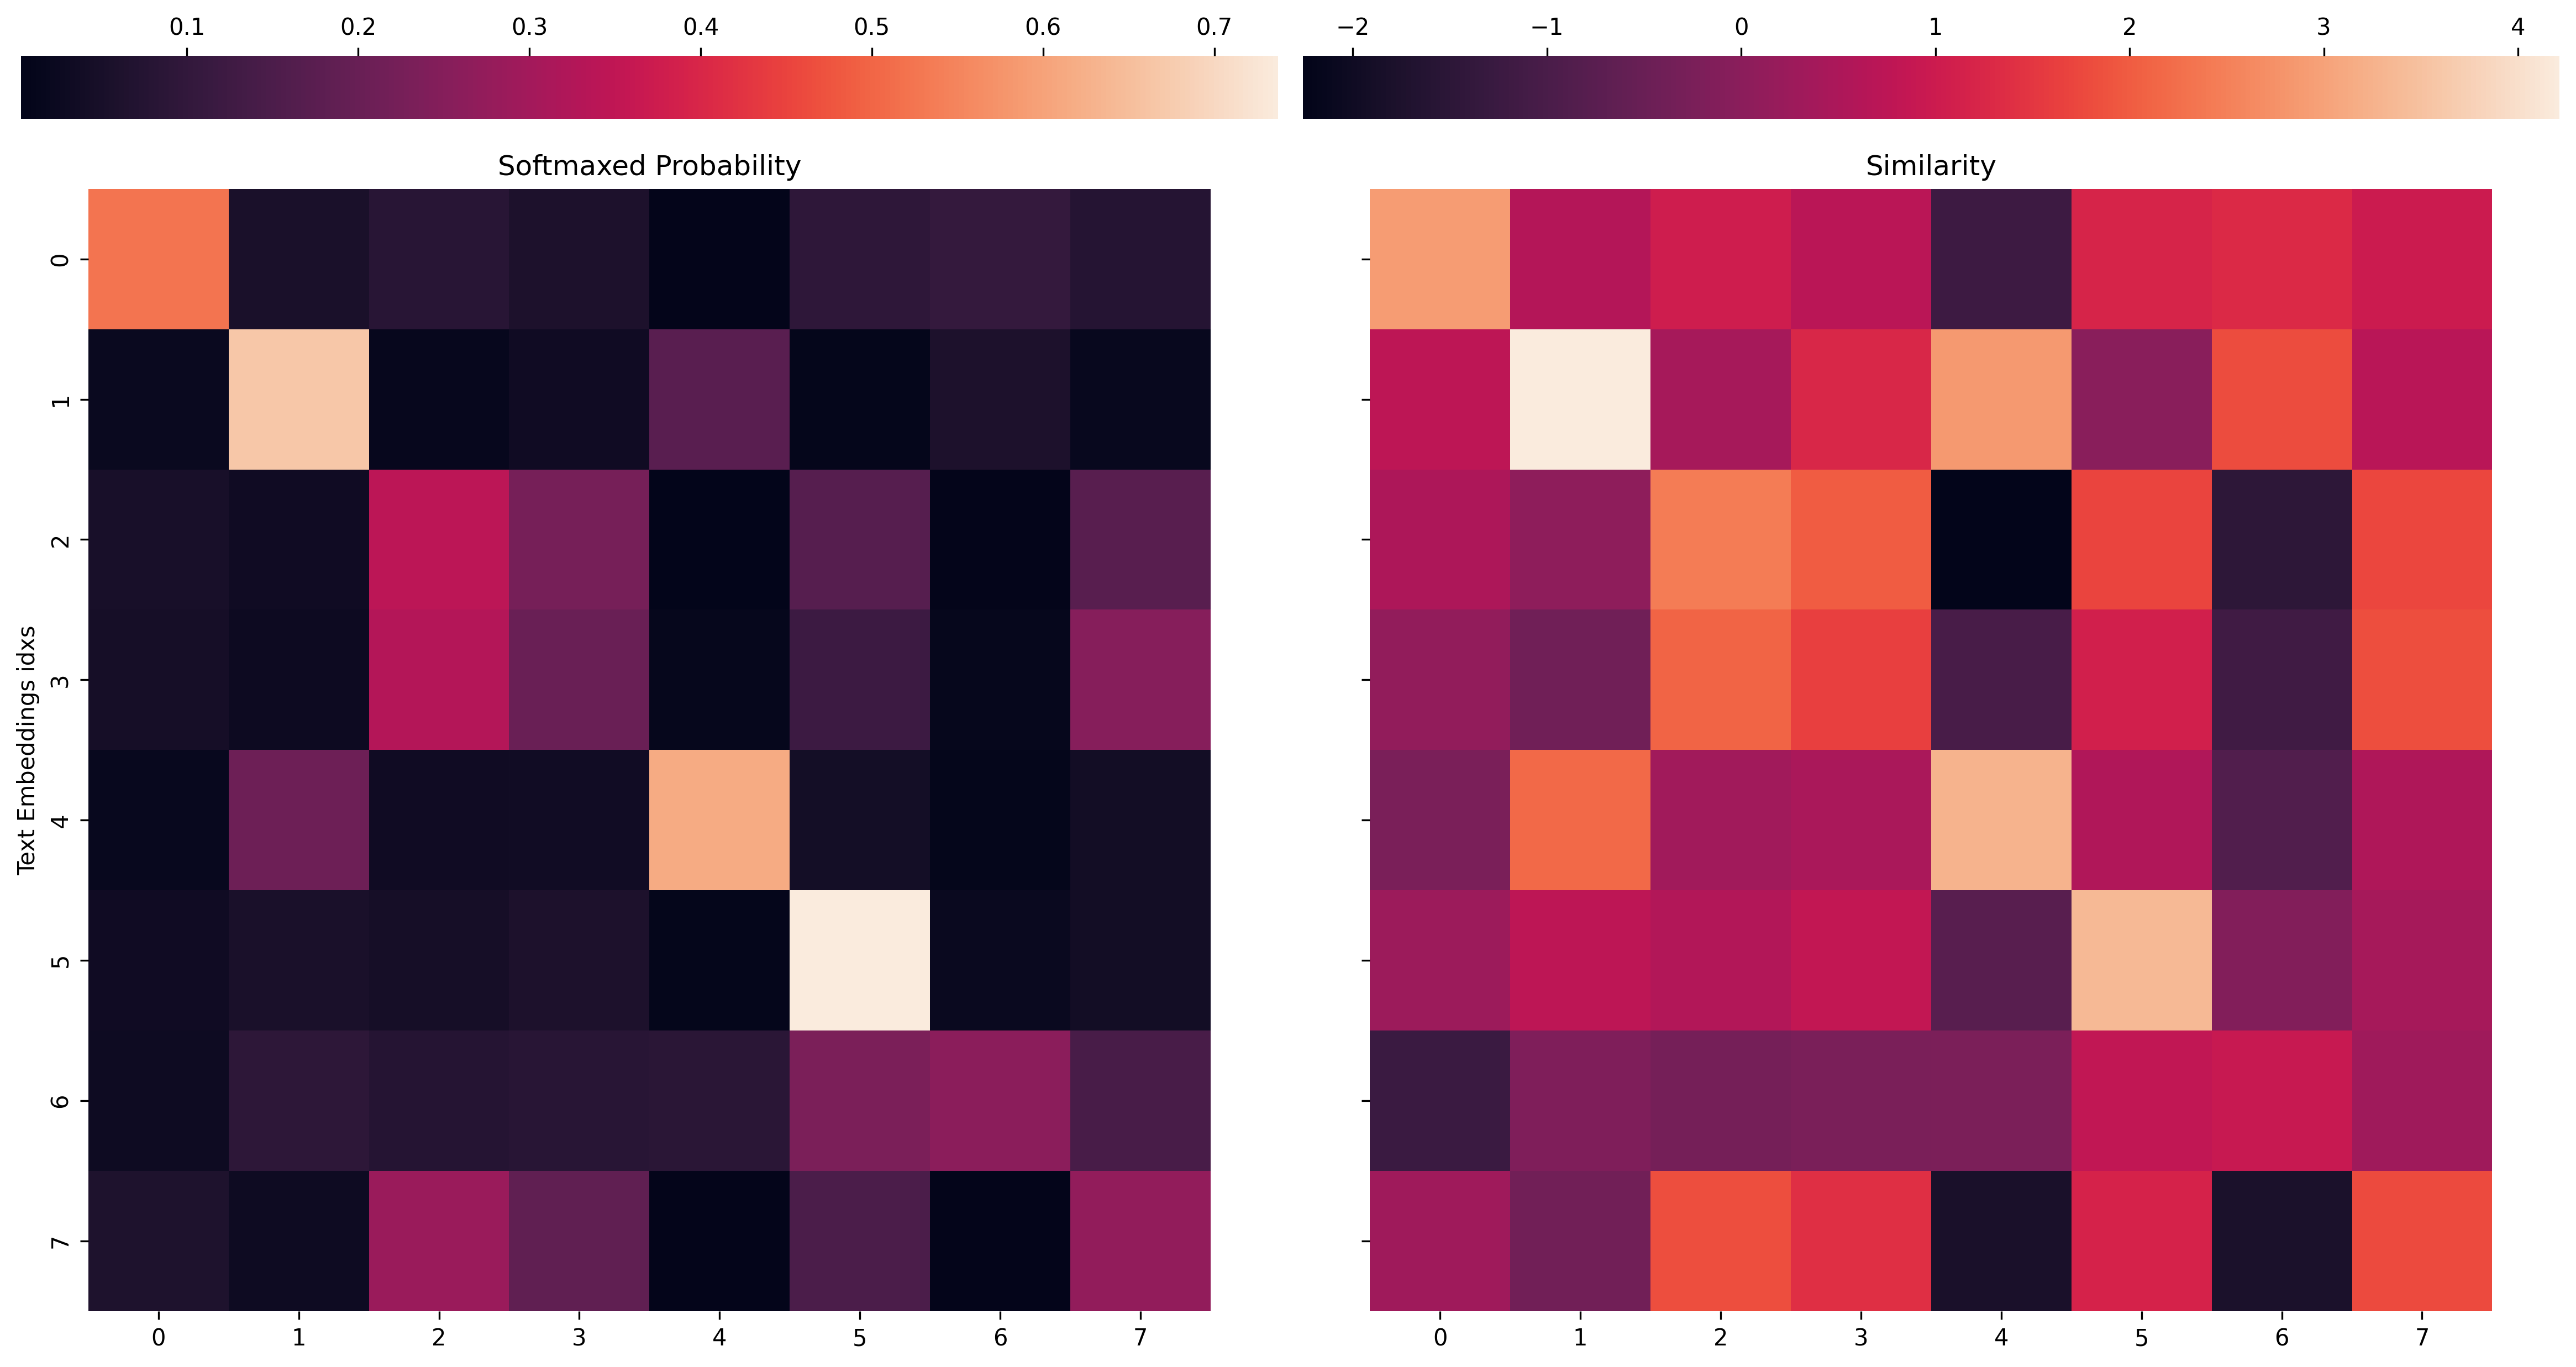

In [11]:
heatmap_pipeline(calvin.val_debug_dataloader())